In [1]:
import pandas as pd
import numpy as np

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing
# Import the ARIMA object
from statsmodels.tsa.arima.model import ARIMA

import random

In [2]:
# Get time series data:
timedata = pd.read_csv('../Ling/SteamCharts.csv',low_memory=False)

# Replace inf to NaN:
timedata = timedata.replace({np.inf:np.nan})
timedata = timedata.replace({'+Inf':np.nan})

In [3]:
# Get Perc_Gain and change data to float.
p_gain = timedata.loc[timedata['Perc_Gain']==1].reset_index(drop=True)

# Get Avg_Players.
avg_players = timedata.loc[timedata['Avg_Players']==1].reset_index(drop=True)
avg_pure = avg_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Peak_Players.
peak_players = timedata.loc[timedata['Peak_Players']==1].reset_index(drop=True)
peak_pure = peak_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

In [4]:
avg_players['max'] = avg_pure.max(axis=1)
avg_pure = avg_pure.drop(avg_players.loc[avg_players['max']<=0].index).drop(avg_players.loc[avg_players['max'].isna()==True].index)
avg_pure = avg_pure.reset_index(drop=True)

p_gain = p_gain.drop(avg_players.loc[avg_players['max']<=0].index).drop(avg_players.loc[avg_players['max'].isna()==True].index)
p_gain = p_gain.reset_index(drop=True)

p_gain_pure = p_gain.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

avg_players = avg_players.drop(avg_players.loc[avg_players['max']<=0].index).drop(avg_players.loc[avg_players['max'].isna()==True].index)
avg_players = avg_players.reset_index(drop=True)

# Add columns 
birth = [avg_pure.iloc[i].last_valid_index() for i in range(len(avg_pure))]
avg_players['birth']=birth
p_gain['birth']=birth

Select games with the max of avg_players larger than or equal to 10 and are created between July 2012 and March 2021. There are 8282 such games.

In [7]:
avg1 = avg_players.loc[avg_players['max']>=10]
avg_pure1 = avg_pure.loc[avg_players['max']>=10]
p_gain1 = p_gain.loc[avg_players['max']>=10]
p_gain_pure1 = p_gain_pure.loc[avg_players['max']>=10]

avg1 = avg1.loc[avg_players['birth']!='July 2012']
avg1 = avg1.loc[avg_players['birth']!='March 2021']
avg1 = avg1.loc[avg_players['birth']!='April 2021'].reset_index(drop=True)

avg_pure1 = avg_pure1.loc[avg_players['birth']!='July 2012']
avg_pure1 = avg_pure1.loc[avg_players['birth']!='March 2021']
avg_pure1 = avg_pure1.loc[avg_players['birth']!='April 2021'].reset_index(drop=True)

p_gain1 = p_gain1.loc[p_gain['birth']!='July 2012']
p_gain1 = p_gain1.loc[p_gain['birth']!='March 2021']
p_gain1 = p_gain1.loc[p_gain['birth']!='April 2021'].reset_index(drop=True)

p_gain_pure1 = p_gain_pure1.loc[p_gain['birth']!='July 2012']
p_gain_pure1 = p_gain_pure1.loc[p_gain['birth']!='March 2021']
p_gain_pure1 = p_gain_pure1.loc[p_gain['birth']!='April 2021'].reset_index(drop=True)

Select games with no NaN data in between

In [8]:
incomplete_data = []
for i in range(len(p_gain1)):
    temp = p_gain_pure1.iloc[i]
    if np.isnan(temp[temp.first_valid_index():temp.last_valid_index()]).any():
        incomplete_data.append(i)
len(incomplete_data)

650

In [11]:
p_gain2 = p_gain1.drop(incomplete_data).reset_index(drop=True)
p_gain_pure2 = p_gain_pure1.drop(incomplete_data).reset_index(drop=True)

There are 650 over 6471 games with missing datas. Probably we can retain some of them if we have time to clean them up

In [12]:
p_gain2

,Name,App_id,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012,birth
0,PLAYERUNKNOWN'S BATTLEGROUNDS,578080,0.0,0.0,1.0,0.0,-2.31,-3.63,-2.94,-1.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,March 2017
1,Apex Legends,1172470,0.0,0.0,1.0,0.0,+22.80,-0.96,4.25,68.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,November 2020
2,Grand Theft Auto V,271590,0.0,0.0,1.0,0.0,-8.15,3.18,-0.94,-10.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,April 2015
3,Destiny 2,1085660,0.0,0.0,1.0,0.0,+17.85,-14.47,-10.18,32.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,October 2019
4,Rust,252490,0.0,0.0,1.0,0.0,-3.80,-10.17,-26.65,-17.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,December 2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,枕边少女 MOE Hypnotist - share dreams with you,942930,0.0,0.0,1.0,0.0,-28.90,-24.93,-30.92,23.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,February 2019
5817,Astrox: Hostile Space Excavation,414720,0.0,0.0,1.0,0.0,+5.06,-17.13,47.76,18.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,December 2015
5818,Transmissions: Element 120,365300,0.0,0.0,1.0,0.0,-2.11,-15.99,-10.19,-10.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,June 2016
5819,Mech Mechanic Simulator: Prologue,1485350,0.0,0.0,1.0,0.0,-23.22,-71.72,-35.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,February 2021


Do exponential smoothing of p_gain for each game.

In [13]:
#Exponential smoothing:

def smooth_values(data, i_game, smoothing_level=.2):

    game_data = data.iloc[i_game]
    months = pd.to_datetime(game_data.index)
    game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
    temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()]
    
    # Fit exponential smoothing
    ses = SimpleExpSmoothing(temp.values)
    fit = ses.fit(smoothing_level=smoothing_level, optimized=False)
    return fit.fittedvalues

In [14]:
# getting the smoothed curve for each game

# Ordered in increasing time order.
smooth_timedata = []
broken_data=[]
for i in range(len(p_gain_pure2)):
    try:
        temp = smooth_values(p_gain_pure2,i)
        if np.isnan(temp).any():
            broken_data.append(i)
        else:
            smooth_timedata.append(temp)
    except:
        broken_data.append(i)

C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [15]:
len(broken_data)

4

Some datas create problems for exponential smoothing. There are only very few of those (72 out of 6792) and they are not played by a large group of players. Here we drop them.

In [16]:
#dropping games with broken data

p_gain_new = p_gain2.drop(index=broken_data).reset_index(drop=True)
p_gain_pure_new = p_gain_pure2.drop(index=broken_data).reset_index(drop=True)

In [17]:
p_gain_new.to_csv('Percentage_Gain_Cleaned.csv')

In [18]:
pd.DataFrame(smooth_timedata).to_csv('Smooth_TimeData_Cleaned.csv')

Now we define the metric.

In [37]:
def rootmse(a, b):
    return np.sqrt(np.sum((a-b)**2))

def Gauss_weight(a, b, epsilon = 20):
    return np.exp(-epsilon*rootmse(a,b)**2)

To compare the shape of 2 curves, we want to compute the scalar that makes 2 curves close together by scaling only.

In [38]:
def mini_scaler(a,b):
    return np.sum(a*b)/np.sum(a**2)

With the weight function and minimizing scalar defined above, we define the weight average function that acts as our prediction.

In [53]:
def wt_avg(game, data, metric = Gauss_weight, epsilon = 20, threshold=0.2, horizon = 4):
    length = len(game)
    game_scaled = game / rootmse(game,0)
    pred = np.zeros(length+horizon)
    close_index = np.zeros((len(data),2))
    j=0
    for i in range(len(data)):
        temp = data[i]
        if len(temp)>=length+horizon:
            temp_scaled = temp * mini_scaler(temp[:length],game_scaled)
            weight=metric(game_scaled,temp_scaled[:length], epsilon = epsilon)
            if weight >= threshold:
                pred = pred + weight * temp_scaled[:length+horizon]
                close_index[j]=[i,weight]
                j=j+1
    if np.max(np.abs(pred)) !=0:
        pred = pred * mini_scaler(pred[:length],game)
    close_index = close_index[:j]
    close_index = close_index[np.argsort(close_index[:, 1])][::-1]
    return pred, close_index

Let's try an example:

In [54]:
subdata = smooth_timedata[0:100]
game = smooth_timedata[200][0:10]
[pred,close_index] = wt_avg(game,subdata, horizon = 4)

len(close_index)

41

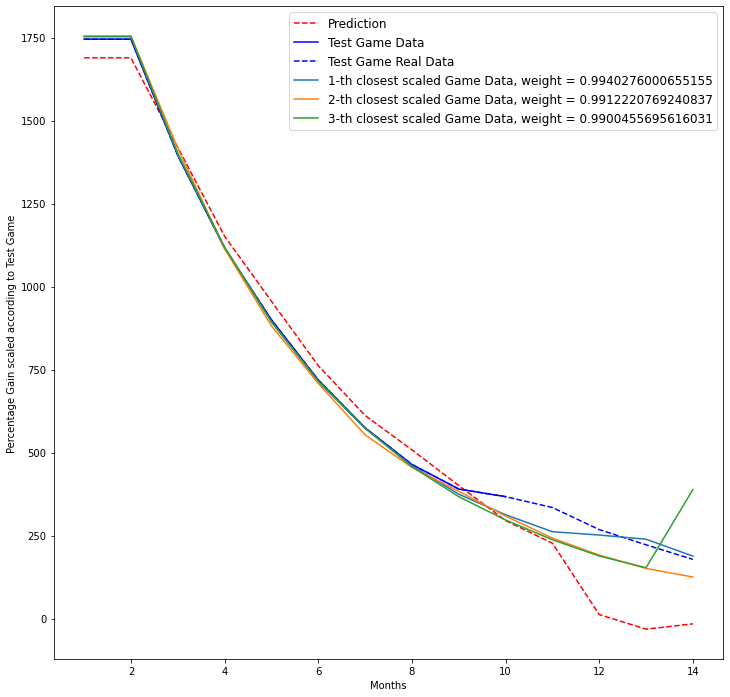

In [55]:
plt.figure(figsize=(12,12))
plt.plot(range(1,len(game)+5), pred, 'r--', label = 'Prediction')
plt.plot(range(1,len(game)+1), game, 'b', label = 'Test Game Data')
plt.plot(range(1,len(game)+5), smooth_timedata[200][:14], 'b--', label = 'Test Game Real Data')

test_range = range(3)
for i in test_range:
    close_game = subdata[int(close_index[i][0])][:len(game)+4]
    scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
    plt.plot(range(1,len(game)+5), scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Months')
plt.ylabel('Percentage Gain scaled according to Test Game')
plt.show()

Let's try the game Among Us

In [81]:
game_index = p_gain_new.loc[p_gain_new['Name']=='Among Us'].index.values[0]

subdata = smooth_timedata[100:2000]
game = smooth_timedata[game_index][0:10]
[pred,close_index] = wt_avg(game,subdata, horizon = 4, threshold = 0.5)

In [82]:
len(close_index)

3

In [83]:
len(pred)

14

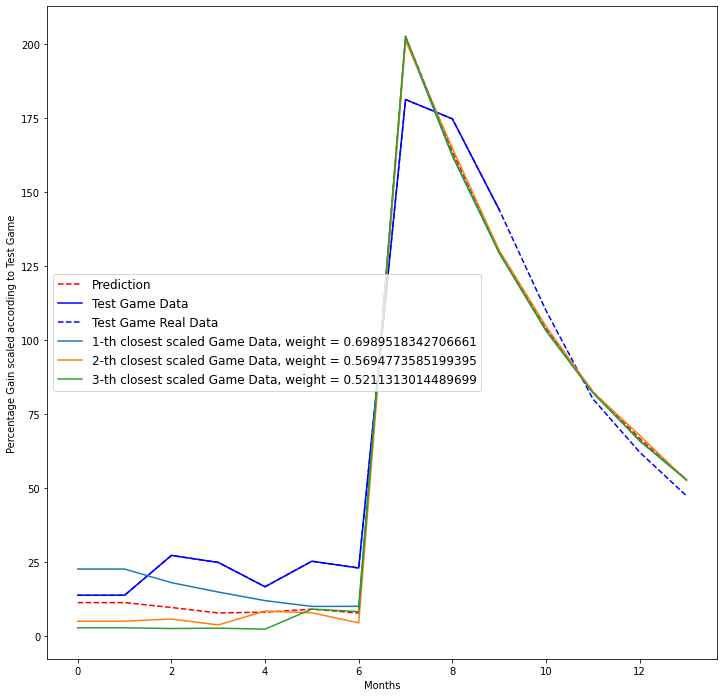

In [84]:
plt.figure(figsize=(12,12))
plt.plot(pred, 'r--', label = 'Prediction')
plt.plot(game, 'b', label = 'Test Game Data')
plt.plot(smooth_timedata[70][:14], 'b--', label = 'Test Game Real Data')

test_range = range(3)
for i in test_range:
    close_game = subdata[int(close_index[i][0])][:len(game)+4]
    scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
    plt.plot(scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Months')
plt.ylabel('Percentage Gain scaled according to Test Game')
plt.show()

Let's focus our attention on predicting 4 horizon given 10 month datas of games we want to predict.

Different horizon or given data may change the accuracy or the best smoothing/metric for prediction.

To check accuracy, we only consider games having 14 months or more data.

In [63]:
#dropping datas with less than 14 months
X = smooth_timedata.copy()
for i in range(len(smooth_timedata)):
    j=len(smooth_timedata)-i-1
    if len(smooth_timedata[j])<14:
        del X[j]

In [64]:
len(X)

4614

Now we do train test split and perform the real data analysis. Due to the nature of the above approach, there is no target.

In [65]:
test_index = random.sample(range(len(X)),int(len(X)/4))
X_test = [X[index] for index in test_index]

train_index = list(range(len(X)))
for i in test_index:
    train_index.remove(i)
X_train = [X[index] for index in train_index]

Now we define the error measurement we want to minimise. Since we used l2 norm, i.e. rootmse, in the above calculation, we also use that here.

In order to calculate average 'percentage error' over the test set, we normalize the error by the l2 norm of the test data. Equivalently, we are normalizing the l2 norm of the predicted values and the test data before computing the error.

Here percentage error refers to the error relative to the l2 norm of test data

In [66]:
def Get_error(train, test, threshold = 0.4, epsilon = 20):
    error = 0
    for i in range(len(test)):
        [pred, close_index] = wt_avg(test[i][:10],train, threshold = threshold, epsilon = epsilon, horizon = 4)
        error = error + rootmse(pred[10:],test[i][10:14]) / np.sum(test[i][10:14]**2)
    error = error / len(test)
    return error

In [78]:
subdata = X_train
game = X_test[20][:10]
[pred,close_index] = wt_avg(game,subdata, horizon = 4, epsilon = 20, threshold = 0.7)

In [79]:
len(close_index)

54

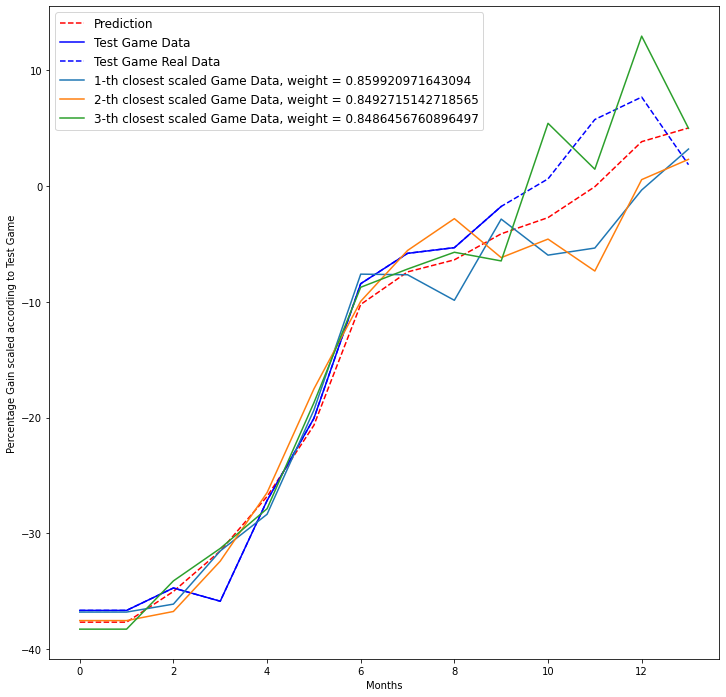

In [80]:
plt.figure(figsize=(12,12))
plt.plot(pred, 'r--', label = 'Prediction')
plt.plot(game, 'b', label = 'Test Game Data')
plt.plot(X_test[20][:14], 'b--', label = 'Test Game Real Data')

test_range = range(3)
for i in test_range:
    close_game = subdata[int(close_index[i][0])][:len(game)+4]
    scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
    plt.plot(scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Months')
plt.ylabel('Percentage Gain scaled according to Test Game')
plt.show()

In [57]:
Get_error(X_train, X_test, threshold = 0.4, epsilon = 1)

0.11485572669456862

In [26]:
def ARIMA_plot(data, i_game,pred_k=14, smoothing_level=.2,order=(1,0,1),scale= 1,title='ARIMA prediction'):

    game_data = data.drop(columns=['Name']).iloc[i_game]
    months = pd.to_datetime(game_data.index)
    game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
    game.Month[-pred_k:]
        
# Use ARIMA smoothing to predict the last k months
    test = game[-pred_k:]
    train = game.drop(test.index)
    arima = ARIMA(train['Data'], order = order)
    fit = arima.fit()

    plt.figure(figsize=(8,6))
    plt.plot(game.Month[:len(game.Month)-pred_k],train['Data'],'b',label = "Training Data")
    plt.plot(game.Month[:len(game.Month)-pred_k],fit.fittedvalues/scale,'r-',label = "Fitted Values")
    
    plt.plot(game.Month[-pred_k:],test['Data']/scale,'b--',label = "Test Data")
    plt.plot(game.Month[-pred_k:],fit.forecast(len(test))/scale,'r--',label = "Forecast")

    plt.legend(fontsize=14)
    plt.xlabel("Month", fontsize=16)
    plt.ylabel('Number of '+title, fontsize=16)
    plt.title(str(data.Name.iloc[i_game]))
    plt.show()

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


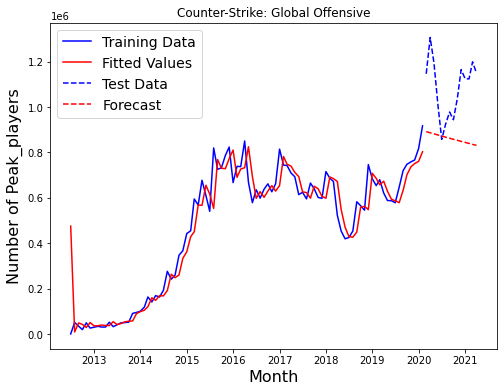

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


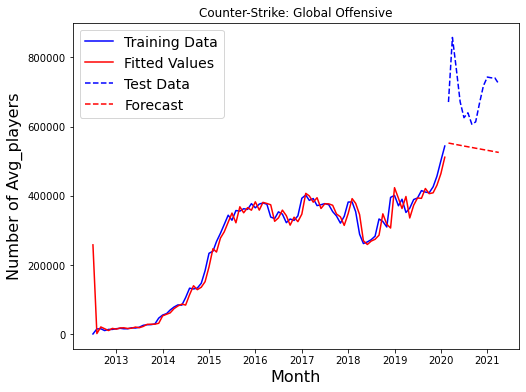

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


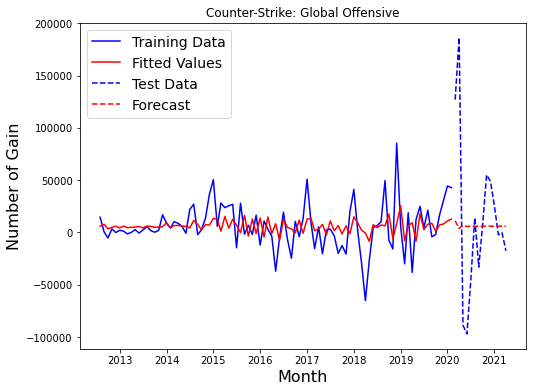

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


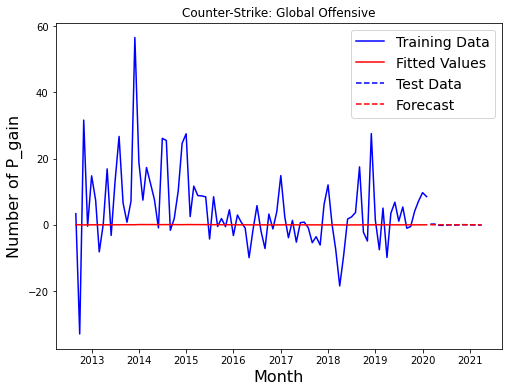

In [27]:
order = (1,0,1)
i = 0

ARIMA_plot(peak_plot, i_game=i,order=order,title='Peak_players')
ARIMA_plot(avg_plot,i_game=i,order=order,title='Avg_players')
ARIMA_plot(gain_plot,pred_k=14, i_game=i,order=order,title='Gain')
ARIMA_plot(p_gain_plot,pred_k=14, i_game=i,order=order,scale=100,title='P_gain')